# Bosque Aleatorio

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Clasificacion

In [3]:
df = pd.read_csv('/content/drive/MyDrive/Inteligencia Artificial Avanzada/car_data.csv')

In [4]:
df.head()

,User ID,Gender,Age,AnnualSalary,Purchased
0,385,Male,35,20000,0
1,681,Male,40,43500,0
2,353,Male,49,74000,0
3,895,Male,40,107500,1
4,661,Male,25,79000,0


In [5]:
from sklearn import preprocessing
gender = preprocessing.LabelEncoder()
gender.fit(df['Gender'].unique().tolist())
df['Gender'] = gender.transform(df['Gender'])

In [6]:
df.head()

,User ID,Gender,Age,AnnualSalary,Purchased
0,385,1,35,20000,0
1,681,1,40,43500,0
2,353,1,49,74000,0
3,895,1,40,107500,1
4,661,1,25,79000,0


# Separación de datos en sets de entrenamiento, validación y prueba

Es una técnica utilizada para construir modelos confiables que no caigan en resultados con bias que den una falsa impresión sobre la precisión de estos. En este caso se van a utilizar un 80% de los datos para entrenar los modelos, un 10% para ir validando con pruebas y al final el 10% restante para probar el modelo.

In [7]:
from sklearn.model_selection import train_test_split

X = df.drop(['Purchased','User ID'], axis = 1) 
y = df['Purchased']   
X_train, X_rem, y_train, y_rem = train_test_split(X, y, test_size=0.20,random_state=9)

In [8]:
X_valid, X_test, y_valid, y_test = train_test_split(X_rem,y_rem, test_size=0.5,random_state=8)

# Modelo Inicial

Este modelo inicial se realiza con los parámetros que tiene por default la librería, entre los que destacan que no tienen límites los árboles generados por lo que se pueden extender hasta donde sean tomando una hoja por cada variable.Esto puede contribuir a un overfitting, por lo que no debería de ser la primera opción el dejarla así. 

Para comprender el overfitting primero se tienen que explicar los conceptos de bias y varianza. El bias es la diferencia entre la predicción promedio que calcula el modelo y el valor real. Y la varianza es la variabilidad de la predicción del modelo contra el valor real. Esto quiere decir que un modelo con un bias alto no aprende bien los datos y por lo tanto va a presentar underfitting. Mientras que un modelo con alta varianza aprendió completamente los datos y por lo tanto presenta overfitting. El objetivo de estas pruebas para optimizar los parámetros es encontrar un equilibrio entre estos dos conceptos para que sea un modelo que haga predicciones correctas.

In [9]:
from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier

clf=RandomForestClassifier()

clf.fit(X_train,y_train)

y_pred=clf.predict(X_valid)
y_pred_1 = clf.predict(X_train)

print("Precisión Entrenamiento:",metrics.accuracy_score(y_train, y_pred_1))
print("Precisión Validación:",metrics.accuracy_score(y_valid, y_pred))

Precisión Entrenamiento: 0.9975
Precisión Validación: 0.89


A pesar de ser un modelo sin optimizar, se obtuvieron muy buenos resultados en cuanto a la precisión con el set de validación. 

Grado de bias y varianza: el set de entrenamiento presenta una alta varianza, ya que se ajusta de gran manera y se aprendió los datos. Para el bias hay un nivel medio, ya que no aprendió más o menos para las predicciones con la validación.

Nivel de ajuste del modelo: Si se compara con el valor de train se observa overfitting, ya que existe una gran diferencia entre las precisiones.



In [10]:
from sklearn.metrics import roc_curve, auc
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_valid, y_pred)
roc_auc = auc(false_positive_rate, true_positive_rate)
roc_auc

0.8909168081494058

Es bueno el puntaje de roc_auc que se utiliza para clasificaciones binarias como en este caso, ya que el máximo valor es de 1. 

In [11]:
from sklearn.model_selection import cross_val_score

scores = cross_val_score(clf, X, y, cv=5)

print("%0.2f accuracy with a standard deviation of %0.2f" % (scores.mean(), scores.std()))

0.90 accuracy with a standard deviation of 0.02


La validación cruzada es una alternativa a la técnica de separar en sets de entrenamiento, validación y prueba. Con la librería de sklearn se puede simular el modelo previo con todo el conjunto de datos y obtener otra métrica con la cual evaluar si el modelo es bueno sin obtener overfitting o underfitting. 

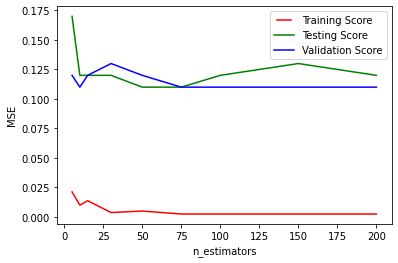

In [12]:
from sklearn.metrics import mean_squared_error
from matplotlib.legend_handler import HandlerLine2D

train_results = []
test_results = []
validation_results = []
list_nb_trees = [5, 10, 15, 30,50,75,100,150,200]

for nb_trees in list_nb_trees:
    clf=RandomForestClassifier(n_estimators=nb_trees)
    clf.fit(X_train, y_train)

    train_results.append(mean_squared_error(y_train, clf.predict(X_train)))
    test_results.append(mean_squared_error(y_test, clf.predict(X_test)))
    validation_results.append(mean_squared_error(y_valid, clf.predict(X_valid)))


line1, = plt.plot(list_nb_trees, train_results, color="r", label="Training Score")
line2, = plt.plot(list_nb_trees, test_results, color="g", label="Testing Score")
line3, = plt.plot(list_nb_trees, validation_results, color="b", label="Validation Score")


plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.ylabel('MSE')
plt.xlabel('n_estimators')
plt.show()

En esta gráfica se comparan los errores cuadrados medios de los diferentes sets de datos al ir aumentando el número de árboles en el bosque. Se puede observar como el set de entrenamiento tiene el valor más bajo de error, y que este se estabiliza después de un gran número de iteraciones. Los otros dos sets tienen que 

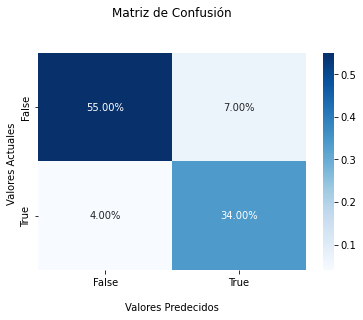

In [13]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

cf_matrix = confusion_matrix(y_valid, y_pred)
ax = sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True, 
            fmt='.2%', cmap='Blues')

ax.set_title('Matriz de Confusión\n\n');
ax.set_xlabel('\nValores Predecidos')
ax.set_ylabel('Valores Actuales ');


ax.xaxis.set_ticklabels(['False','True'])
ax.yaxis.set_ticklabels(['False','True'])


plt.show()

Se puede observar con la matriz de confusión que los errores de clasificación son mínimos y que más que nada hay falsos positivos. 

# Busqueda para encontrar los mejores parámetros 

0.9968944099378882
0.8909168081494058


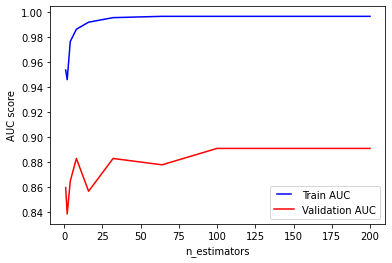

In [14]:
n_estimators = [1, 2, 4, 8, 16, 32, 64, 100, 200]
train_results = []
test_results = []
for estimator in n_estimators:
   rf = RandomForestClassifier(n_estimators=estimator, n_jobs=-1)
   rf.fit(X_train, y_train)
   train_pred = rf.predict(X_train)
   false_positive_rate, true_positive_rate, thresholds = roc_curve(y_train, train_pred)
   roc_auc = auc(false_positive_rate, true_positive_rate)
   train_results.append(roc_auc)
   y_pred = rf.predict(X_valid)
   false_positive_rate, true_positive_rate, thresholds = roc_curve(y_valid, y_pred)
   roc_auc = auc(false_positive_rate, true_positive_rate)
   test_results.append(roc_auc)
from matplotlib.legend_handler import HandlerLine2D
print(max(train_results))
print(max(test_results))
line1, = plt.plot(n_estimators, train_results, 'b', label='Train AUC')
line2, = plt.plot(n_estimators, test_results, 'r', label='Validation AUC')
plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.ylabel('AUC score')
plt.xlabel('n_estimators')
plt.show()

De este gráfica se puede rescatar el número de estimadores que son necesarios, donde se puede observar que llega un momento en el que los dos sets se estabilizan que es a partir del 100.

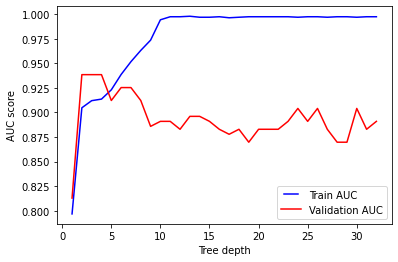

In [15]:
max_depths = np.linspace(1, 32, 32, endpoint=True)
train_results = []
test_results = []
for max_depth in max_depths:
   rf = RandomForestClassifier(max_depth=max_depth, n_jobs=-1)
   rf.fit(X_train, y_train)
   train_pred = rf.predict(X_train)
   false_positive_rate, true_positive_rate, thresholds = roc_curve(y_train, train_pred)
   roc_auc = auc(false_positive_rate, true_positive_rate)
   train_results.append(roc_auc)
   y_pred = rf.predict(X_valid)
   false_positive_rate, true_positive_rate, thresholds = roc_curve(y_valid, y_pred)
   roc_auc = auc(false_positive_rate, true_positive_rate)
   test_results.append(roc_auc)
from matplotlib.legend_handler import HandlerLine2D
line1, = plt.plot(max_depths, train_results, 'b', label='Train AUC')
line2, = plt.plot(max_depths, test_results, 'r', label='Validation AUC')
plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.ylabel('AUC score')
plt.xlabel('Tree depth')
plt.show()

En esta se puede observar que hay un punto en el que está subiendo el puntaje con el set de validación y llega a ser el mismo que con el set de entrenamiento. Después de esto al seguir subiendo el nivel de profundidad se genera overfitting, ya que mejora el set de entrenamiento y varía el de validación.

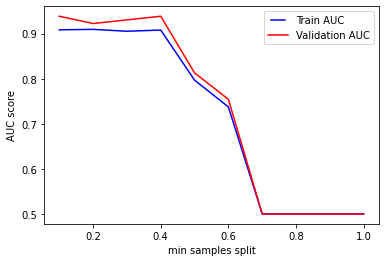

In [16]:
min_samples_splits = np.linspace(0.1, 1.0, 10, endpoint=True)
train_results = []
test_results = []
for min_samples_split in min_samples_splits:
   rf = RandomForestClassifier(min_samples_split=min_samples_split)
   rf.fit(X_train, y_train)
   train_pred = rf.predict(X_train)
   false_positive_rate, true_positive_rate, thresholds = roc_curve(y_train, train_pred)
   roc_auc = auc(false_positive_rate, true_positive_rate)
   train_results.append(roc_auc)
   y_pred = rf.predict(X_valid)
   false_positive_rate, true_positive_rate, thresholds = roc_curve(y_valid, y_pred)
   roc_auc = auc(false_positive_rate, true_positive_rate)
   test_results.append(roc_auc)
from matplotlib.legend_handler import HandlerLine2D
line1, = plt.plot(min_samples_splits, train_results, 'b', label='Train AUC')
line2, = plt.plot(min_samples_splits, test_results, 'r', label='Validation AUC')
plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.ylabel('AUC score')
plt.xlabel('min samples split')
plt.show()

Los puntajes son cada iguales, por lo que este parámetro no contribuye al overfitting, y se puede observar de la importancia de que este valor sea bajo. 

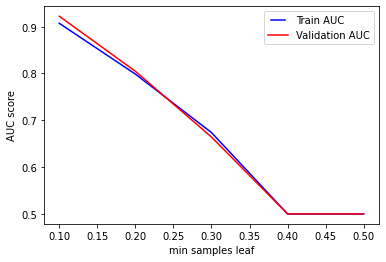

In [17]:
min_samples_leafs = np.linspace(0.1, 0.5, 5, endpoint=True)
train_results = []
test_results = []
for min_samples_leaf in min_samples_leafs:
   rf = RandomForestClassifier(min_samples_leaf=min_samples_leaf)
   rf.fit(X_train, y_train)
   train_pred = rf.predict(X_train)
   false_positive_rate, true_positive_rate, thresholds = roc_curve(y_train, train_pred)
   roc_auc = auc(false_positive_rate, true_positive_rate)
   train_results.append(roc_auc)
   y_pred = rf.predict(X_valid)
   false_positive_rate, true_positive_rate, thresholds = roc_curve(y_valid, y_pred)
   roc_auc = auc(false_positive_rate, true_positive_rate)
   test_results.append(roc_auc)
from matplotlib.legend_handler import HandlerLine2D
line1, = plt.plot(min_samples_leafs, train_results, 'b', label='Train AUC')
line2, = plt.plot(min_samples_leafs, test_results, 'r', label='Validation AUC')
plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.ylabel('AUC score')
plt.xlabel('min samples leaf')
plt.show()

Algo parecido al parámetro anterior, no cambian mucho entre los dos sets, y hay que cuidar que sea bajo.

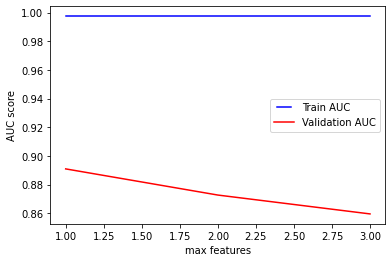

In [18]:
max_features = [1,2,3]
train_results = []
test_results = []
for max_feature in max_features:
   rf = RandomForestClassifier(max_features=max_feature)
   rf.fit(X_train, y_train)
   train_pred = rf.predict(X_train)
   false_positive_rate, true_positive_rate, thresholds = roc_curve(y_train, train_pred)
   roc_auc = auc(false_positive_rate, true_positive_rate)
   train_results.append(roc_auc)
   y_pred = rf.predict(X_valid)
   false_positive_rate, true_positive_rate, thresholds = roc_curve(y_valid, y_pred)
   roc_auc = auc(false_positive_rate, true_positive_rate)
   test_results.append(roc_auc)
from matplotlib.legend_handler import HandlerLine2D
line1, = plt.plot(max_features, train_results, 'b', label='Train AUC')
line2, = plt.plot(max_features, test_results, 'r', label='Validation AUC')
plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.ylabel('AUC score')
plt.xlabel('max features')
plt.show()

De aquí se puede rescatar que son necesarios todos los features posibles.

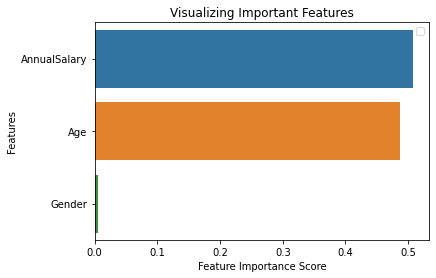

In [19]:
names = list(X_test.columns)
feature_imp = pd.Series(clf.feature_importances_,index=names).sort_values(ascending=False)
sns.barplot(x=feature_imp, y=feature_imp.index)

plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title("Visualizing Important Features")
plt.legend()
plt.show()

En el análisis de la importancia de cada variable para el modelo se puede observar que la variable de género no aporta al modelo.

# Modelos conforme a las pruebas realizadas

In [20]:
X_train_1 = X_train.drop(['Gender'],axis=1)
X_valid_1 = X_valid.drop(['Gender'],axis=1)
X_test_1 = X_test.drop(['Gender'],axis=1)

## Modelo 1

In [21]:
clf_1=RandomForestClassifier(n_estimators = 100,max_depth=6,random_state=0)

clf_1.fit(X_train_1,y_train)

y_pred=clf_1.predict(X_valid_1)
y_pred_1 = clf_1.predict(X_train_1)
y_pred_3 = clf_1.predict(X_test_1)


print("Precisión Entrenamiento:",metrics.accuracy_score(y_train, y_pred_1))
print("Precisión Validación:",metrics.accuracy_score(y_valid, y_pred))
print("Precisión Testeo:",metrics.accuracy_score(y_test, y_pred_3))

Precisión Entrenamiento: 0.94125
Precisión Validación: 0.91
Precisión Testeo: 0.93


In [22]:
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_valid, y_pred)
roc_auc = auc(false_positive_rate, true_positive_rate)
roc_auc

0.9121392190152801

El modelo sin la variable previamente mencionada y tomando en cuenta los dos parámetros más significativos en las pruebas arrojó muy buenos resultados. Se observa que hay menor overfitting que en el modelo original, y que existe una una buena combinación entre el nivel de varianza y el de bias, los cuales se podrían decir que están en un nivel bajo.

## Modelo 2

In [23]:
from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier

clf=RandomForestClassifier(max_depth=6,n_estimators=150, min_samples_leaf=0.1,random_state=0,min_samples_split=0.1)

clf.fit(X_train,y_train)

y_pred=clf.predict(X_valid)
y_pred_1 = clf.predict(X_train)
y_pred_2 = clf.predict(X_test)


print("Precisión Entrenamiento:",metrics.accuracy_score(y_train, y_pred_1))
print("Precisión Validación:",metrics.accuracy_score(y_valid, y_pred))
print("Precisión Testeo:",metrics.accuracy_score(y_test, y_pred_2))

Precisión Entrenamiento: 0.89375
Precisión Validación: 0.89
Precisión Testeo: 0.87


In [24]:
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_valid, y_pred)
roc_auc = auc(false_positive_rate, true_positive_rate)
roc_auc

0.8909168081494058

Al poner los parámetros que más aumentaran la precisión con el set de validación se benefició unicamente este y bajaron las precisiones con los otros dos sets, por lo que no es el modelo correcto.

## Modelo 3

In [25]:
clf=RandomForestClassifier(max_depth=6,random_state=0)

clf.fit(X_train,y_train)

y_pred=clf.predict(X_valid)
y_pred_1 = clf.predict(X_train)
y_pred_2 = clf.predict(X_test)


print("Precisión Entrenamiento:",metrics.accuracy_score(y_train, y_pred_1))
print("Precisión Validación:",metrics.accuracy_score(y_valid, y_pred))
print("Precisión Testeo:",metrics.accuracy_score(y_test, y_pred_2))

Precisión Entrenamiento: 0.9325
Precisión Validación: 0.91
Precisión Testeo: 0.89


In [26]:
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_valid, y_pred)
roc_auc = auc(false_positive_rate, true_positive_rate)
roc_auc

0.9121392190152801

Un modelo bastante simple que tiene buen equilibrio entre la varianza y bias, por lo cual no tiene overfitting o underfitting. Este modelo se realizó debido a que es de los parámetros que mayor precisión proporcionaban en las pruebas.

# Métricas de Desempeño

A partir de los resultados de los modelos, se puede observar que el mejor fue el primero, el cual tuvo la mejor precisión en todos los sets.

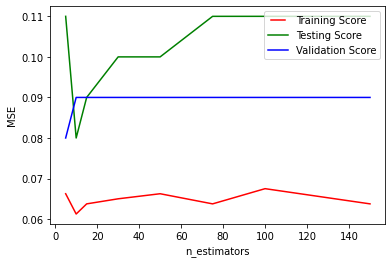

In [27]:
train_results = []
test_results = []
validation_results = []
list_nb_trees = [5, 10, 15, 30,50,75,100,150]

for nb_trees in list_nb_trees:
    clf=RandomForestClassifier(max_depth=6,random_state=0, n_estimators=nb_trees)
    clf.fit(X_train, y_train)

    train_results.append(mean_squared_error(y_train, clf.predict(X_train)))
    test_results.append(mean_squared_error(y_test, clf.predict(X_test)))
    validation_results.append(mean_squared_error(y_valid, clf.predict(X_valid)))


line1, = plt.plot(list_nb_trees, train_results, color="r", label="Training Score")
line2, = plt.plot(list_nb_trees, test_results, color="g", label="Testing Score")
line3, = plt.plot(list_nb_trees, validation_results, color="b", label="Validation Score")


plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.ylabel('MSE')
plt.xlabel('n_estimators')
plt.show()

In [28]:
from sklearn.model_selection import cross_val_score

scores = cross_val_score(clf_1, X, y, cv=5)

print("%0.2f accuracy with a standard deviation of %0.2f" % (scores.mean(), scores.std()))

0.91 accuracy with a standard deviation of 0.01


Con la cross validation se pudo obtener una precisión bastante alta que refleja el equilibrio entre las precisiones obtenidas con los sets diferentes. 

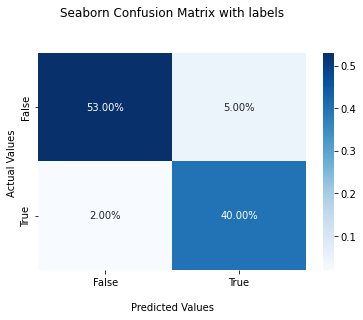

In [29]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

cf_matrix = confusion_matrix(y_test, y_pred_3)
ax = sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True, 
            fmt='.2%', cmap='Blues')

ax.set_title('Seaborn Confusion Matrix with labels\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');


ax.xaxis.set_ticklabels(['False','True'])
ax.yaxis.set_ticklabels(['False','True'])


plt.show()

# Comparación de modelos 



*   Precisión 

Modelo Original: 

Entrenamiento: 0.9975
Validación: 0.87

Modelo 1: 

Entrenamiento: 0.94125
Validación: 0.91
Testeo: 0.93

Modelo 2:

Entrenamiento: 0.89375
Validación: 0.89
Testeo: 0.87

Modelo 3:

Entrenamiento: 0.9325
Validación: 0.91
Testeo: 0.89

*   Roc-AUC

Modelo Original: 0.86969

Modelo 1:
0.9121

Modelo 2:
0.8909

Modelo 3:
0.9121




*   Validación Cruzada

Modelo original:
0.90

Modelo 1:
0.91

Por medio de estas métricas de evaluación se puede observar cómo mejoró el modelo para realizar mejores predicciones. 

Conclusión del modelo de clasificación: Al principio presentaba unos cuantos errores de overfitting, entonces la idea era optimizar los parámetros para encontrar un modelo que tuviera un balance con todos los sets de entrenamiento. En el modelo elegido se puede considerar que se logró el balance entre el bias y la varianza, por lo cual se obtuvo un modelo con la capacidad de predecir muy buena.

# Regresion

In [30]:
df_1 = pd.read_csv('/content/drive/MyDrive/Inteligencia Artificial Avanzada/insurance.csv')

In [31]:
df_1.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


# Variables Categóricas a númericas

In [32]:
sex = preprocessing.LabelEncoder()
sex.fit(df_1['sex'].unique().tolist())
df_1['sex'] = sex.transform(df_1['sex'])

In [33]:
smoker = preprocessing.LabelEncoder()
smoker.fit(df_1['smoker'].unique().tolist())
df_1['smoker'] = smoker.transform(df_1['smoker'])

In [34]:
region = preprocessing.LabelEncoder()
region.fit(df_1['region'].unique().tolist())
df_1['region'] = region.transform(df_1['region'])

In [35]:
df_1.head()

,age,sex,bmi,children,smoker,region,charges
0,19,0,27.900,0,1,3,16884.92400
1,18,1,33.770,1,0,2,1725.55230
2,28,1,33.000,3,0,2,4449.46200
3,33,1,22.705,0,0,1,21984.47061
4,32,1,28.880,0,0,1,3866.85520


# Separación de datos

In [36]:
X = df_1.drop(['charges'], axis = 1) 
y = df_1['charges']   

X_train, X_rem, y_train, y_rem = train_test_split(X, y, test_size=0.20,random_state=5)

In [37]:
X_valid, X_test, y_valid, y_test = train_test_split(X_rem,y_rem, test_size=0.5,random_state=5)

# Modelo simple

Al igual que con clasificación se utilizan los parámetros por default que contiene la librería de bosques aleatorios, pero ahora de tipo regresión.

In [38]:
from sklearn.ensemble import RandomForestRegressor

forest=RandomForestRegressor()


forest.fit(X_train,y_train)

y_prediction = forest.predict(X_valid)
y_prediction_2 = forest.predict(X_train)

In [39]:
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error

score = r2_score(y_valid,y_prediction)
score_2 = r2_score(y_train,y_prediction_2)
print('r2 score del set de entrenamiento ',score_2)
print('r2 score del set de validacion ',score)

print('mean_sqrd_error es==',mean_squared_error(y_valid,y_prediction))
print('root_mean_squared error of es==',np.sqrt(mean_squared_error(y_valid,y_prediction)))

r2 score del set de entrenamiento  0.9764064656973306
r2 score del set de validacion  0.8072701861686596
mean_sqrd_error es== 22593008.28704765
root_mean_squared error of es== 4753.210313782428


Se obtiene un r2 bastante bueno para el set de entrenamiento, pero con el de validación se puede interpretar que hay overfitting debido a la gran diferencia entre puntajes. Podemos decir que este modelo tiene una alta varianza con un bias bajo.

In [40]:
scores = cross_val_score(forest, X, y, cv=5)

print("%0.2f accuracy with a standard deviation of %0.2f" % (scores.mean(), scores.std()))

0.83 accuracy with a standard deviation of 0.03


Con el cross validation se puede dar una idea de la realidad del modelo, siendo que es una precisión buena más no excelente como ocurría con el set de entrenamiento.

# Gráfica de error 

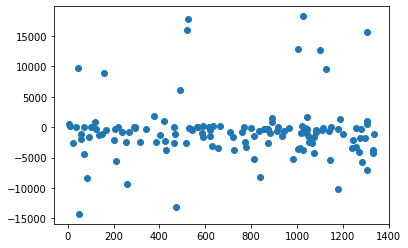

In [41]:
g=plt.plot(y_valid - y_prediction,marker='o',linestyle='')

# Mejoras para el modelo

Con la función de randomized search que ofrece sklearn se puede intentar encontrar los mejores parámetros para el modelo. Se le proporciona una variación de los valores que podría tomar cada parámetro y la función se encarga de probar con todas las combinaciones posibles para asi regresar el modelo con los parámetros que mejor se ajusten.

In [42]:
from sklearn.model_selection import RandomizedSearchCV

n_estimators = [int(x) for x in np.linspace(start = 20, stop = 500, num = 10)]

max_features = ['auto', 'sqrt']

max_depth = [int(x) for x in np.linspace(1, 300, num = 10)]
max_depth.append(None)

min_samples_split = [2, 5, 10]

min_samples_leaf = [1, 2, 4,6,8]

bootstrap = [True, False]

random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
print(random_grid)


{'n_estimators': [20, 73, 126, 180, 233, 286, 340, 393, 446, 500], 'max_features': ['auto', 'sqrt'], 'max_depth': [1, 34, 67, 100, 133, 167, 200, 233, 266, 300, None], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4, 6, 8], 'bootstrap': [True, False]}


In [43]:
rf = RandomForestRegressor()

rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=5, n_jobs = -1)

rf_random.fit(X_train, y_train)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


RandomizedSearchCV(cv=3, estimator=RandomForestRegressor(), n_iter=100,
                   n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [1, 34, 67, 100, 133, 167,
                                                      200, 233, 266, 300,
                                                      None],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 2, 4, 6, 8],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [20, 73, 126, 180, 233,
                                                         286, 340, 393, 446,
                                                         500]},
                   random_state=5, verbose=2)

In [44]:
print ('Random grid: ', random_grid, '\n')

print ('Best Parameters: ', rf_random.best_params_, ' \n')

Random grid:  {'n_estimators': [20, 73, 126, 180, 233, 286, 340, 393, 446, 500], 'max_features': ['auto', 'sqrt'], 'max_depth': [1, 34, 67, 100, 133, 167, 200, 233, 266, 300, None], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4, 6, 8], 'bootstrap': [True, False]} 

Best Parameters:  {'n_estimators': 286, 'min_samples_split': 5, 'min_samples_leaf': 8, 'max_features': 'auto', 'max_depth': 100, 'bootstrap': True}  



# Modelo Optimizado

In [45]:
from sklearn.ensemble import RandomForestRegressor

forest=RandomForestRegressor(n_estimators= 20, min_samples_split= 2, min_samples_leaf= 8, bootstrap= True,max_features= 'auto',max_depth=266)


forest.fit(X_train,y_train)

y_prediction_2 = forest.predict(X_train)
y_prediction = forest.predict(X_valid)

In [46]:
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error

score=r2_score(y_valid,y_prediction)
score_2 = r2_score(y_train,y_prediction_2)

print('r2 score del set de entrenamiento es ',score_2)
print('r2 score del set de validacion es ',score)

print('mean_sqrd_error del set validación es==',mean_squared_error(y_valid,y_prediction))
print('root_mean_squared error of es==',np.sqrt(mean_squared_error(y_valid,y_prediction)))

r2 score del set de entrenamiento es  0.8863940380298194
r2 score del set de validacion es  0.8659840753544538
mean_sqrd_error del set validación es== 15710194.680947782
root_mean_squared error of es== 3963.6087951446193


In [47]:
y_prediction = forest.predict(X_test)


score=r2_score(y_test,y_prediction)
print('r2 score del set de prueba es',score)
print('mean_sqrd_error es==',mean_squared_error(y_test,y_prediction))
print('root_mean_squared error es==',np.sqrt(mean_squared_error(y_test,y_prediction)))

r2 score del set de prueba es 0.9115681744394798
mean_sqrd_error es== 16464944.151002586
root_mean_squared error es== 4057.701831209704


Se utilizan los parámetros actualizados y se obtiene una mejor en la precisión de todos los sets, pero por alguna razón el set de prueba es el que mejores resultados obtiene 

In [48]:
scores = cross_val_score(forest, X, y, cv=5)

print("%0.2f accuracy with a standard deviation of %0.2f" % (scores.mean(), scores.std()))

0.85 accuracy with a standard deviation of 0.03


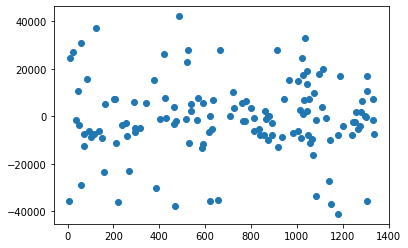

In [49]:
g=plt.plot(y_valid - y_prediction,marker='o',linestyle='')

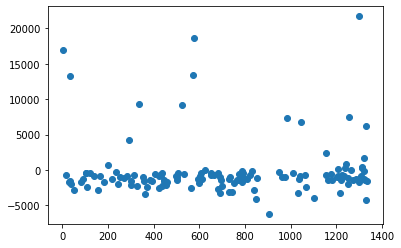

In [50]:
g=plt.plot(y_test - y_prediction,marker='o',linestyle='')

# Comparación de Modelos



*   Puntaje R2

Modelo Original

Entrenamiento  0.976406
Validacion  0.80727

Modelo Optimizado

Entrenamiento es  0.8863
Validacion es  0.8659
Testeo 0.911568


*   Validación Cruzada

Modelo Original 

0.83

Modelo Optimizado

0.85


Se puede observar cómo el modelo mejoró gracias a la optimización de hiperparámetros. 

Conclusión modelo de regresión:
El mismo objetivo que con el modelo de clasificación, y se utilizó un acercamiento diferente al utilizar la librería de grid search que de manera automática buscó los mejores parámetros. Se obtuvieron resultados que mejoraron el modelo inicial, y se redujo la varianza para el set de entrenamiento. Es un buen modelo para las predicciones, pero el de validación no es el mejor. 